# FISH - Pipeline - A Python interactive notebook to process FISH data

```
Author: Luis U. Aguilera
Contact Info: luis.aguilera@colostate.edu

Copyright (c) 2021 Munsky Group 
Colorado State University 
Licensed under BSD 3-Clause License.
```

### Notebook summary 


- Load a directory with microscope FISH images
- Establish a connection to Network-attached storage (NAS) using [pysmb](https://github.com/miketeo/pysmb)
- Perform cell segmentation using [Cellpose](https://github.com/MouseLand/cellpose)
- Perform spot detection using [Big-FISH](https://github.com/fish-quant/big-fish)
- Datamanagement using Pandas

----

<img src= /home/luisub/Desktop/FISH_Processing/docs/images/code_architecture.png alt="drawing" width="1000"/>

### Libraries

In [1]:
# Importing libraries
import sys
import pathlib
import warnings
warnings.filterwarnings("ignore")

### Path to source directories

In [2]:
# Defining directories
current_dir = pathlib.Path().absolute()
fa_dir = current_dir.parents[0].joinpath('src')

# Importing fish_analyses module
sys.path.append(str(fa_dir))
import fish_analyses as fa

In [3]:
fa.Banner().print_banner()

 
FISH processing repository by : 
Luis U. Aguilera, Joshua Cook, Tim Stasevich, and Brian Munsky. 
 ____________________________________________________________  
|                      ,#^^^^^^^%&&&                         | 
|  .&.                 &.           ,&&&___                  | 
|  &  &         ___&&&/                    (&&&&____         | 
|  &    &,____#&                   .       #.       %&**,    | 
|  /(                  &         ,%       &       %     ,&   | 
|    &          &.                       %.      %&%     &*  | 
|     &&         *         .%            &             &(    | 
|   &                &(           ,#     .%             ,.&  | 
|  &    _&&__#&.     &&           &.      ,&         ,%&     | 
|  &  (%        #&,___                      (-***%&%^        | 
|  & &                %&&&(,.      .*#&&&&&%.                | 
|                          &    ,%%%%                        | 
|___________________________/%%^_____________________________| 



----

# Parameters defined by the user 

----

### Paths to images

In [4]:
# Path to credentials
desktop_path = pathlib.Path.home()/'Desktop'
path_to_config_file = desktop_path.joinpath('config.yml')
# Path to images and masks
#data_folder_path =pathlib.Path('smFISH_images/Eric_smFISH_images/20220131/DUSP1_Dex_75min')
#path_to_masks_dir = None 


data_folder_path =pathlib.Path('smFISH_images/Eric_smFISH_images/20230306/DUSP1_0nM_Dex_0min_012623')
path_to_masks_dir = None 

#data_folder_path =pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_5hTPL_5uM')
#path_to_masks_dir = pathlib.Path('smFISH_images/Linda_smFISH_images/Confocal/20220714/MS2-CY5_Cyto543_560_5hTPL_5uM/masks_MS2-CY5_Cyto543_560_5hTPL_5uM___nuc_70__cyto_0.zip') 

### Parameters for segmentation and spot detection

In [5]:
diameter_nucleus=100                        # Approximate nucleus size in pixels
diameter_cytosol=200                         # Approximate cytosol size in pixels
psf_z=350                                  # Theoretical size of the PSF emitted by a [rna] spot in the z plan, in nanometers
psf_yx=160                                 # Theoretical size of the PSF emitted by a [rna] spot in the yx plan, in nanometers
voxel_size_z=500                           # Microscope conversion px to nanometers in the z axis.
voxel_size_yx=160                          # Microscope conversion px to nanometers in the xy axis.
channels_with_nucleus=[2]                  # Channel to pass to python for nucleus segmentation
channels_with_cytosol=[1]                 # Channel to pass to python for cytosol segmentation
channels_with_FISH=[0]                   # Channel to pass to python for spot detection
optimization_segmentation_method='z_slice_segmentation' # optimization_segmentation_method = 'intensity_segmentation' 'z_slice_segmentation', 'gaussian_filter_segmentation' , None
save_all_images=0  
save_filtered_images = False 
number_of_images_to_process = 2  # None
minimum_spots_cluster = 2
threshold_for_spot_detection=None
show_plots=1
send_data_to_NAS=0                         # If data sent back to NAS use 1
download_data_from_NAS=1                   # If data downloaded from NAS use 1

## Downloading data from NAS

In [6]:
# Download data from NAS
local_data_dir, masks_dir, _, _, list_files_names = fa.Utilities.read_images_from_folder( path_to_config_file, data_folder_path, 
                                                                        path_to_masks_dir,  download_data_from_NAS)


Connection established
File Downloaded : ROI017_XY1678131751_Z00_T0_C1.tif
File Downloaded : ROI022_XY1678131756_Z00_T0_C0.tif
File Downloaded : ROI008_XY1678130393_Z00_T0_C2.tif
File Downloaded : ROI018_XY1678131752_Z00_T0_C1.tif
File Downloaded : ROI020_XY1678131754_Z00_T0_C0.tif
File Downloaded : ROI025_XY1678131759_Z00_T0_C2.tif
File Downloaded : ROI011_XY1678130396_Z00_T0_C1.tif
File Downloaded : ROI004_XY1678130389_Z00_T0_C2.tif
File Downloaded : ROI016_XY1678131750_Z00_T0_C2.tif
File Downloaded : ROI006_XY1678130391_Z00_T0_C1.tif
File Downloaded : ROI027_XY1678131761_Z00_T0_C0.tif
File Downloaded : ROI019_XY1678131753_Z00_T0_C2.tif
File Downloaded : ROI028_XY1678131762_Z00_T0_C0.tif
File Downloaded : ROI001_XY1678130386_Z00_T0_C1.tif
File Downloaded : ROI024_XY1678131758_Z00_T0_C1.tif
File Downloaded : ROI030_XY1678131764_Z00_T0_C1.tif
File Downloaded : ROI014_XY1678130399_Z00_T0_C2.tif
File Downloaded : ROI011_XY1678130396_Z00_T0_C0.tif
File Downloaded : ROI020_XY1678131754_Z00

## Running the pipeline

----

Folder name:  DUSP1_0nM_Dex_0min_012623___nuc_100__cyto_200__psfz_350__psfyx_160__ts_550
 ############### 
       IMAGE : 0
 ############### 
 
ORIGINAL IMAGE
ROI001_XY1678130386_Z00_T0_merged.tif
(27, 896, 600, 3)


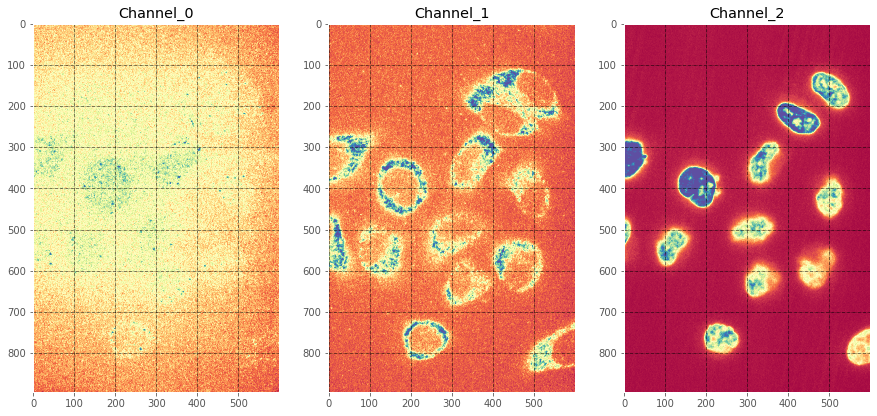

CELL SEGMENTATION
SPOT DETECTION
Spot Detection for Channel : 0
sigma_value (z,y,x) = (0.7, 1.0, 1.0)
Int threshold used for the detection of spots:  550
not showing elbow plot
Z-Slice:  13


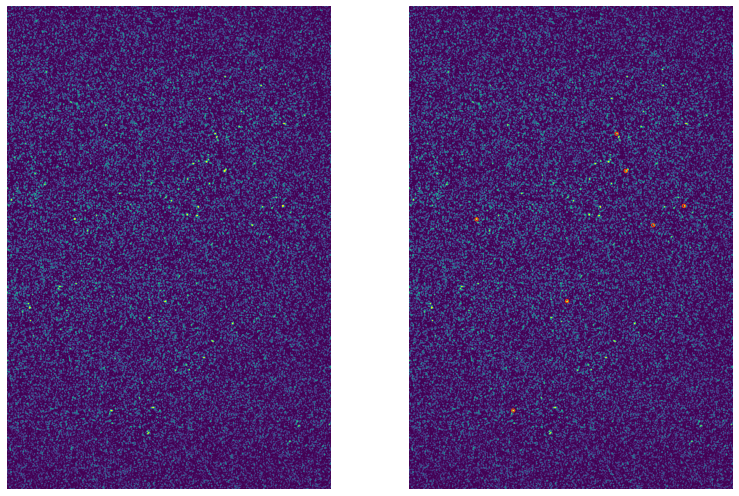

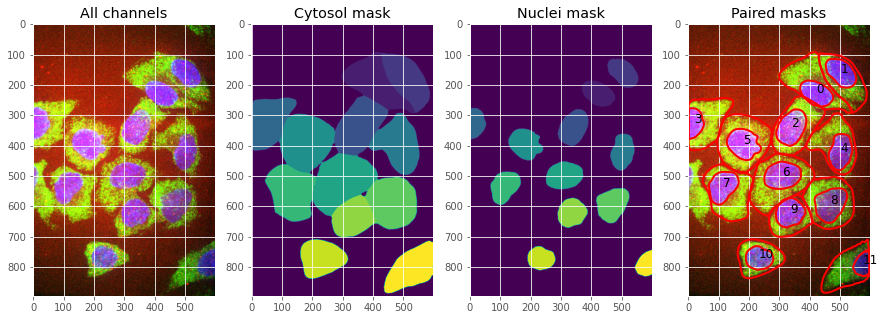

 ############### 
       IMAGE : 1
 ############### 
 
ORIGINAL IMAGE
ROI002_XY1678130387_Z00_T0_merged.tif
(27, 896, 600, 3)


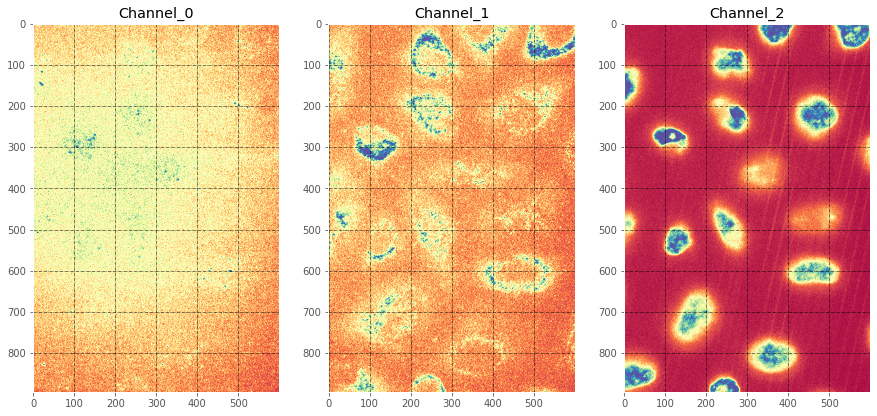

CELL SEGMENTATION


In [7]:
dataframe_FISH,_,_,_,output_identification_string = fa.PipelineFISH(local_data_dir, channels_with_cytosol, channels_with_nucleus, channels_with_FISH,diameter_nucleus, 
                                       diameter_cytosol, minimum_spots_cluster, masks_dir=masks_dir,  voxel_size_z=voxel_size_z,
                                       voxel_size_yx=voxel_size_yx ,psf_z=psf_z,psf_yx=psf_yx, show_plots=show_plots,  
                                       file_name_str =data_folder_path.name, optimization_segmentation_method = optimization_segmentation_method,
                                       save_all_images=save_all_images,threshold_for_spot_detection=threshold_for_spot_detection,save_filtered_images=save_filtered_images,
                                       number_of_images_to_process=number_of_images_to_process).run()

## Extracting data from the dataframe

----

In [ ]:
# Be aware that the code keeps track of cells without spots. In the data frame, the fields for cells without spots are populated with -1 values.
dataframe_FISH.tail()

## Plots

In [ ]:
list_files_distributions = fa.Plots.plot_all_distributions (dataframe_FISH,channels_with_cytosol, channels_with_nucleus,channels_with_FISH,minimum_spots_cluster,output_identification_string )

In [ ]:
file_plots_bleed_thru = fa.Plots.plot_scatter_bleed_thru(dataframe_FISH, channels_with_cytosol, channels_with_nucleus,output_identification_string)

## Saving data

In [ ]:
# Saving data and plots, and sending data to NAS
fa.Utilities.save_output_to_folder(output_identification_string, data_folder_path, list_files_distributions=list_files_distributions,
                                   file_plots_bleed_thru=file_plots_bleed_thru)

# sending data to NAS
analysis_folder_name, mask_dir_complete_name = fa.Utilities.sending_data_to_NAS(output_identification_string, data_folder_path, path_to_config_file, path_to_masks_dir, diameter_nucleus, diameter_cytosol, send_data_to_NAS, masks_dir)

# Moving the complete analysis folder to final analyses folder 
fa.Utilities.move_results_to_analyses_folder( output_identification_string, data_folder_path, mask_dir_complete_name, path_to_masks_dir, save_filtered_images, download_data_from_NAS )